In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seaborn import boxplot
import re
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import Model, Input
from keras.layers import Embedding, LSTM, Dense, Concatenate, AdditiveAttention, TimeDistributed, Bidirectional
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.nist_score import corpus_nist
pd.options.mode.chained_assignment = None

In [2]:
df = pd.read_csv('jpn.txt', sep='\t', header=None)
df.head()

,0,1,2
0,Go.,行け。,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,Go.,行きなさい。,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
2,Hi.,こんにちは。,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
3,Hi.,もしもし。,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
4,Hi.,やっほー。,CC-BY 2.0 (France) Attribution: tatoeba.org #5...


# 1. Data Preprocessing

In [3]:
df = df[[1, 0]]
df.columns = ['JAP', 'EN']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93356 entries, 0 to 93355
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   JAP     93356 non-null  object
 1   EN      93356 non-null  object
dtypes: object(2)
memory usage: 1.4+ MB


In [4]:
# Text cleaning.

df['JAP'] = df['JAP'].apply(lambda row: row.strip())
df['EN'] = df['EN'].apply(lambda row: re.sub('([.,!?()])', r' \1 ', row).strip())
df['EN'] = df['EN'].apply(lambda row: re.sub('\s{2,}', ' ', row))

In [5]:
# Add special tokens.

df['EN_Train'] = '<start> ' + df['EN']
df['EN'] = df['EN'] + ' <end>'

df.head()

,JAP,EN,EN_Train
0,行け。,Go . <end>,<start> Go .
1,行きなさい。,Go . <end>,<start> Go .
2,こんにちは。,Hi . <end>,<start> Hi .
3,もしもし。,Hi . <end>,<start> Hi .
4,やっほー。,Hi . <end>,<start> Hi .


In [6]:
jap_sen_len = df['JAP'].apply(lambda row: len(list(row)))
en_sen_len = df['EN'].apply(lambda row: len(row.split()))

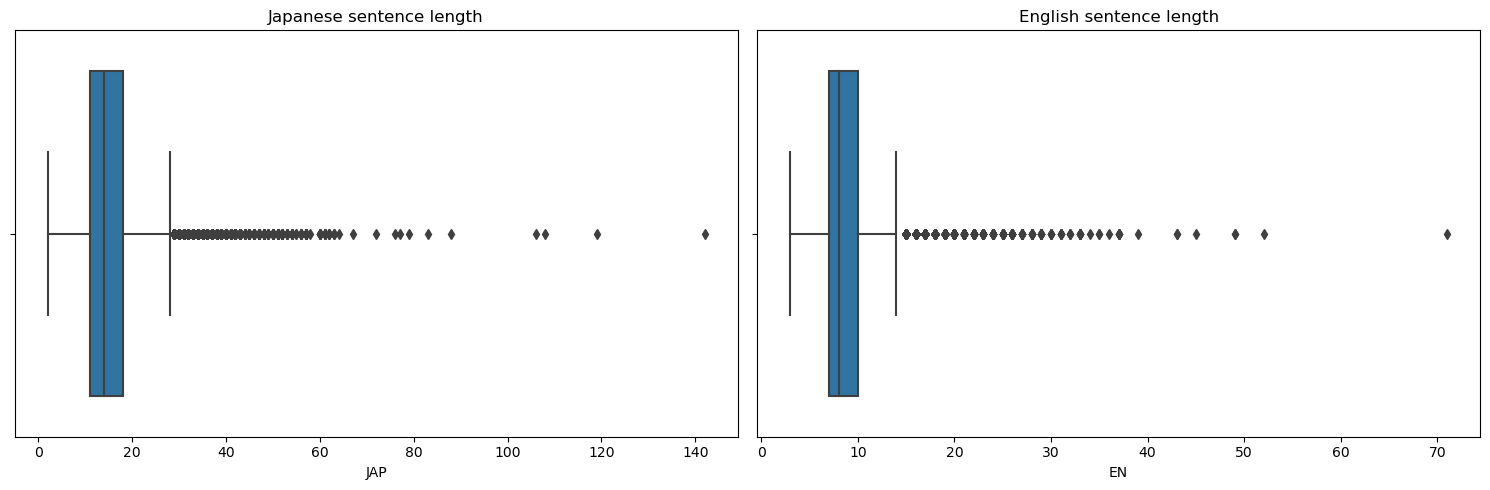

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
boxplot(x=jap_sen_len, ax=ax[0])
boxplot(x=en_sen_len, ax=ax[1])
ax[0].title.set_text('Japanese sentence length')
ax[1].title.set_text('English sentence length')
plt.tight_layout()
plt.show()

In [8]:
jap_Q1 = np.percentile(jap_sen_len, 25, method='midpoint')
jap_Q3 = np.percentile(jap_sen_len, 75, method='midpoint')
jap_IQR = jap_Q3 - jap_Q1

en_Q1 = np.percentile(en_sen_len, 25, method='midpoint')
en_Q3 = np.percentile(en_sen_len, 75, method='midpoint')
en_IQR = en_Q3 - en_Q1

max_jap_len = round(jap_Q3 + 1.5 * jap_IQR)
max_en_len = round(en_Q3 + 1.5 * en_IQR)
print('Max JAP length:', max_jap_len)
print('Max EN length:', max_en_len)

Max JAP length: 28
Max EN length: 14


In [9]:
# Remove rows with excessive length.

df = df[df.apply(lambda row: len(list(row['JAP'])) <= max_jap_len and len(row['EN'].split()) <= max_en_len, axis=1)]
df.shape

(89386, 3)

In [10]:
# Split train test.

df_train = pd.DataFrame(columns=['JAP', 'EN', 'EN_Train'])
df_test = pd.DataFrame(columns=['JAP', 'EN'])

_, df_test['JAP'], df_train['EN'], df_test['EN'] = train_test_split(df['JAP'], df['EN'], test_size=0.05, random_state=0)
df_train['JAP'], _, df_train['EN_Train'], _ = train_test_split(df['JAP'], df['EN_Train'], test_size=0.05, random_state=0)

df_test['EN'] = df_test['EN'].str.replace(' <end>', '')
df.reset_index(drop=True, inplace=True)
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [11]:
print('Train set:', len(df_train))
print('Test set:', len(df_test))

Train set: 84916
Test set: 4470


In [12]:
# Tokenize text.

jap_tokenizer = Tokenizer(filters='', char_level=True, oov_token='UNK')
jap_tokenizer.fit_on_texts(df['JAP'])
jap_vocab_size = len(jap_tokenizer.word_index)
jap_ids = jap_tokenizer.texts_to_sequences(df_train['JAP'])

en_tokenizer = Tokenizer(filters='', oov_token='UNK')
en_tokenizer.fit_on_texts('<start> ' + df['EN'])
en_vocab_size = len(en_tokenizer.word_index)
en_train_ids = en_tokenizer.texts_to_sequences(df_train['EN_Train'])
en_ids = en_tokenizer.texts_to_sequences(df_train['EN'])

In [13]:
print('Japanese vocabulary size:', jap_vocab_size)
print('English vocabulary size:', en_vocab_size)

Japanese vocabulary size: 2475
English vocabulary size: 11220


In [14]:
# Pad text to equal length.

jap_ids = pad_sequences(jap_ids, maxlen=max_jap_len, dtype=int, padding='pre', value=0)
en_train_ids = pad_sequences(en_train_ids, maxlen=max_en_len, dtype=int, padding='post', value=0)
en_ids = pad_sequences(en_ids, maxlen=max_en_len, dtype=int, padding='post', value=0)

In [15]:
print('jap_ids[0]:\n', jap_ids[0])
print('en_train_ids[0]:\n', en_train_ids[0])
print('en_ids[0]:\n', en_ids[0])

jap_ids[0]:
 [  0   0   0   0   0   0   0   0   0   0   0   0   0 113   5  42  31 176
  11  21  13   3  15  24  25  18  60   2]
en_train_ids[0]:
 [   2  132 2419 2216   18  300    8    9    0    0    0    0    0    0]
en_ids[0]:
 [ 132 2419 2216   18  300    8    9    3    0    0    0    0    0    0]


# 2. Model Training

In [16]:
# Encoder-decoder architecture with attenttion layer.

LSTM_UNITS = 64

encoder_input = Input(shape=(max_jap_len,), name='encoder_input')
encoder_embedding_layer = Embedding(jap_vocab_size+1, 64, mask_zero=True, input_length=max_jap_len, name='encoder_embedding')
encoder_embedding = encoder_embedding_layer(encoder_input)
encoder_mask = encoder_embedding_layer.compute_mask(encoder_input)
encoder_output, en_fwd_h, en_fwd_c, en_bwd_h, en_bwd_c = Bidirectional(LSTM(int(LSTM_UNITS/2), return_sequences=True, return_state=True), name='encoder_biLSTM')(encoder_embedding)
encoder_h = Concatenate(name='encoder_h')([en_fwd_h, en_bwd_h])
encoder_c = Concatenate(name='encoder_c')([en_fwd_c, en_bwd_c])
encoder_states = [encoder_h, encoder_c]

decoder_input = Input(shape=(max_en_len,), name='decoder_input')
decoder_embedding_layer = Embedding(en_vocab_size+1, 128, mask_zero=True, name='decoder_embedding')
decoder_embedding = decoder_embedding_layer(decoder_input)
decoder_mask = decoder_embedding_layer.compute_mask(decoder_input)
decoder_layer = LSTM(LSTM_UNITS, return_sequences=True, return_state=True, name='decoder_LSTM')
decoder_output, _, _ = decoder_layer(decoder_embedding, initial_state=encoder_states)

attention_layer = AdditiveAttention(name='Bahdanau_attention')
attention = attention_layer([decoder_output, encoder_output], mask=[decoder_mask, encoder_mask])
concat_layer = Concatenate(name='attention_map')
concat = concat_layer([decoder_output, attention])

output_layer = TimeDistributed(Dense(en_vocab_size+1, activation='softmax'), name='output')
output = output_layer(concat)
model = Model([encoder_input, decoder_input], output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28)]         0           []                               
                                                                                                  
 encoder_embedding (Embedding)  (None, 28, 64)       158464      ['encoder_input[0][0]']          
                                                                                                  
 decoder_input (InputLayer)     [(None, 14)]         0           []                               
                                                                                                  
 encoder_biLSTM (Bidirectional)  [(None, 28, 64),    24832       ['encoder_embedding[0][0]']      
                                 (None, 32),                                                  

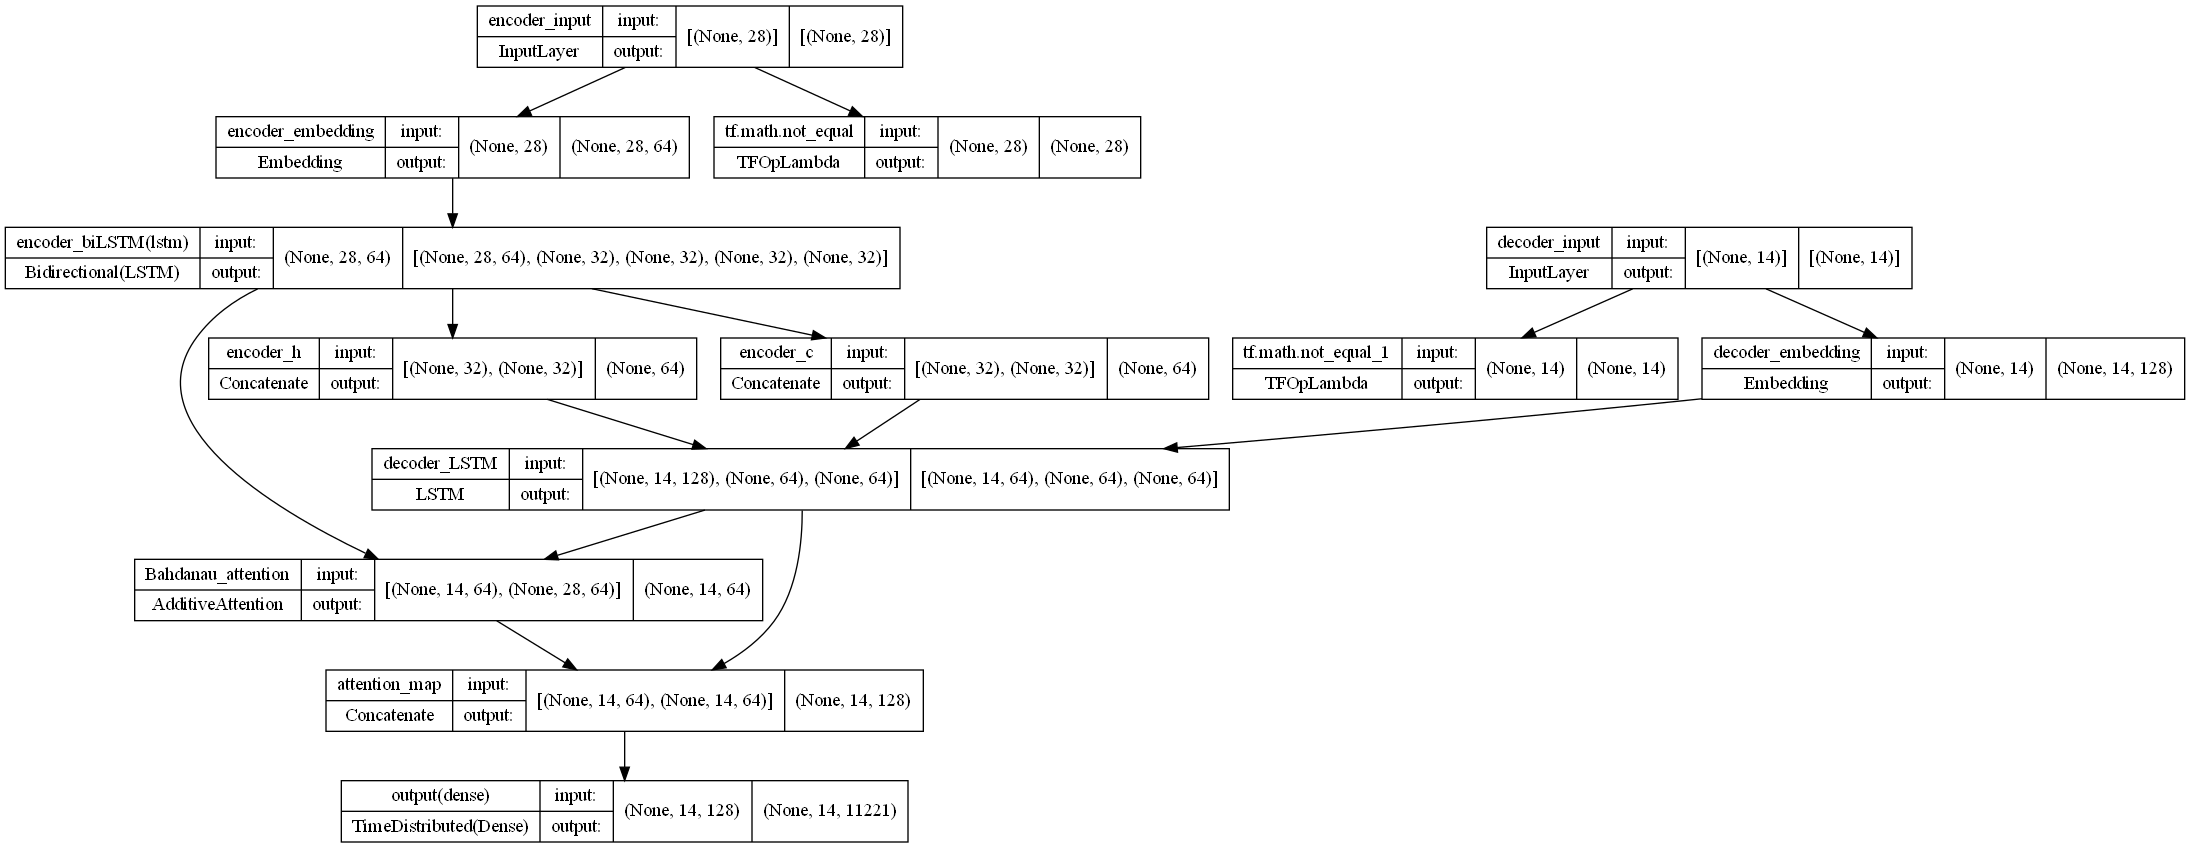

In [17]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [18]:
# Configure early stopping.

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    mode='min',
    restore_best_weights=True,
)

In [19]:
# Train model.

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_hist = model.fit([jap_ids, en_train_ids],
                       en_ids,
                       batch_size=128,
                       epochs=30,
                       validation_split=0.2,
                       callbacks=[early_stopping])

Epoch 1/30
531/531 [==============================] - 527s 887ms/step - loss: 3.0457 - accuracy: 0.2292 - val_loss: 2.5987 - val_accuracy: 0.3098
Epoch 2/30
531/531 [==============================] - 461s 867ms/step - loss: 2.4075 - accuracy: 0.3457 - val_loss: 2.2997 - val_accuracy: 0.3639
Epoch 3/30
531/531 [==============================] - 460s 866ms/step - loss: 2.1711 - accuracy: 0.3803 - val_loss: 2.1267 - val_accuracy: 0.3906
Epoch 4/30
531/531 [==============================] - 460s 866ms/step - loss: 1.9937 - accuracy: 0.4083 - val_loss: 1.9805 - val_accuracy: 0.4151
Epoch 5/30
531/531 [==============================] - 461s 868ms/step - loss: 1.8372 - accuracy: 0.4345 - val_loss: 1.8556 - val_accuracy: 0.4379
Epoch 6/30
531/531 [==============================] - 462s 870ms/step - loss: 1.6992 - accuracy: 0.4598 - val_loss: 1.7516 - val_accuracy: 0.4591
Epoch 7/30
531/531 [==============================] - 462s 870ms/step - loss: 1.5764 - accuracy: 0.4847 - val_loss: 1.6604 -

In [20]:
model.save('model.h5')

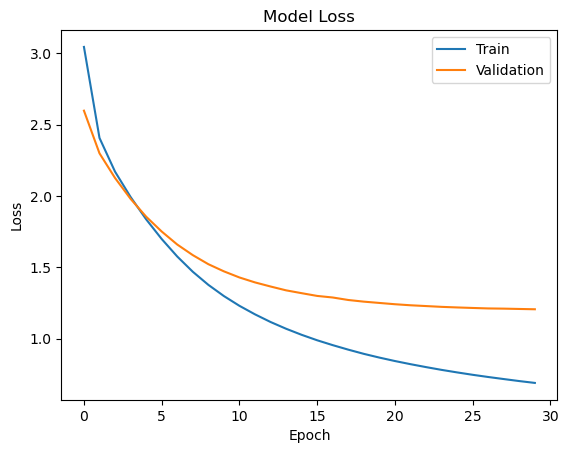

In [21]:
plt.plot(model_hist.history['loss'], label='Train')
plt.plot(model_hist.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

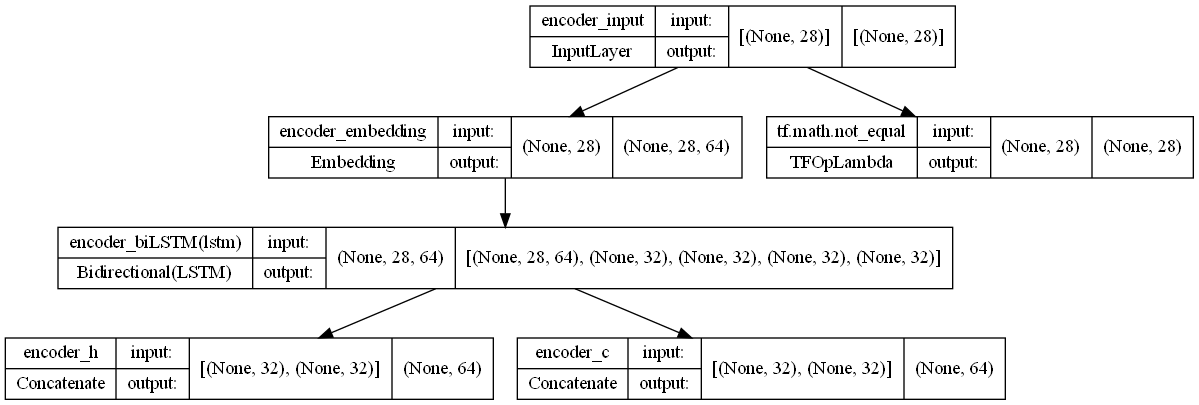

In [22]:
encoder_inf_model = Model(encoder_input, [encoder_output, encoder_h, encoder_c, encoder_mask])
plot_model(encoder_inf_model, show_shapes=True, show_layer_names=True)

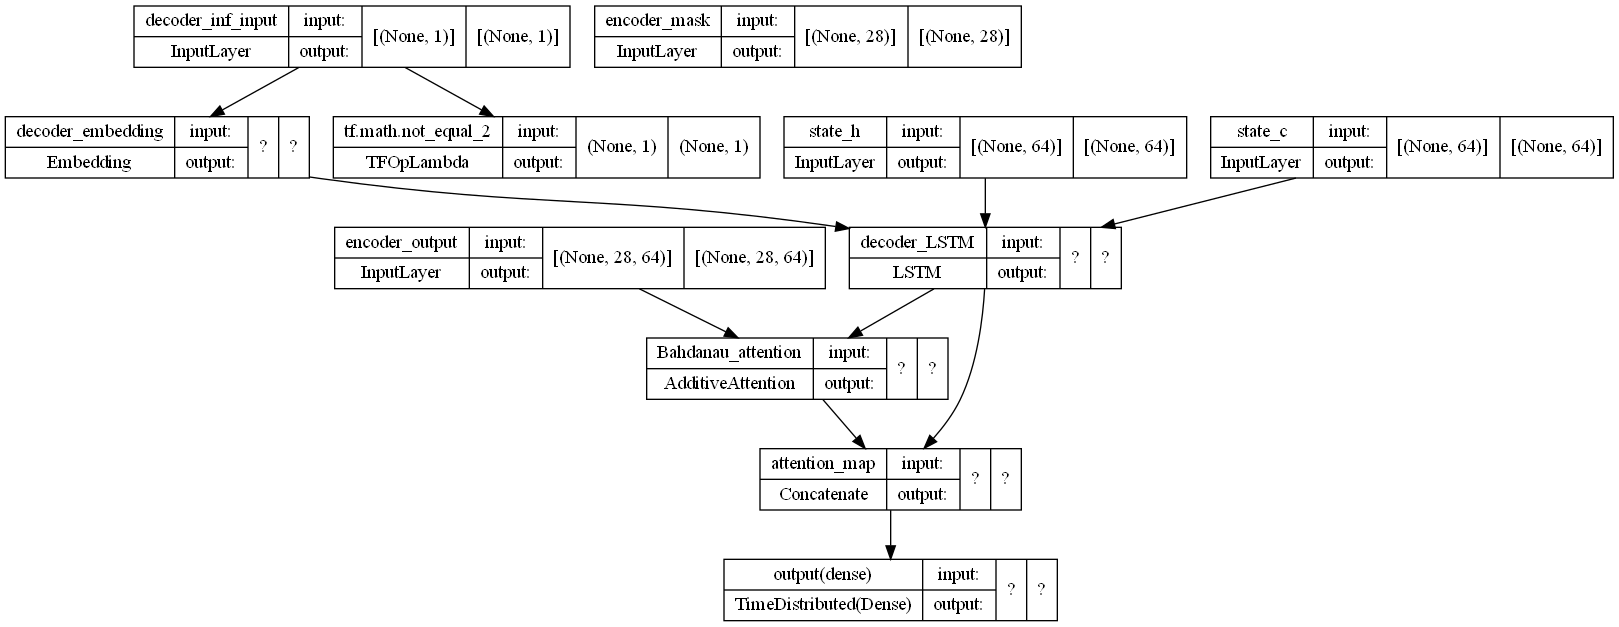

In [23]:
# Inference model.

encoder_inf_output = Input(shape=(max_jap_len, LSTM_UNITS), name='encoder_output')
encoder_inf_mask = Input(shape=(max_jap_len,), dtype='bool', name='encoder_mask')
decoder_inf_input = Input(shape=(1,), name='decoder_inf_input')
inf_h = Input(shape=(LSTM_UNITS,), name='state_h')
inf_c = Input(shape=(LSTM_UNITS,), name='state_c')
inf_states = [inf_h, inf_c]

decoder_inf_embedding = decoder_embedding_layer(decoder_inf_input)
decoder_inf_mask = decoder_embedding_layer.compute_mask(decoder_inf_input)
decoder_inf_output, decoder_inf_h, decoder_inf_c = decoder_layer(decoder_inf_embedding, initial_state=inf_states)

decoder_inf_attention = attention_layer([decoder_inf_output, encoder_inf_output], mask=[decoder_inf_mask, encoder_inf_mask])
decoder_inf_concat = concat_layer([decoder_inf_output, decoder_inf_attention])

inf_output = output_layer(decoder_inf_concat)
inf_model = Model([encoder_inf_output, encoder_inf_mask, decoder_inf_input, inf_h, inf_c], 
                  [inf_output, decoder_inf_h, decoder_inf_c])

plot_model(inf_model, show_shapes=True, show_layer_names=True)

In [24]:
# Token to word dictionary.

idx2word_jap = {v:k for k, v in jap_tokenizer.word_index.items()}
idx2word_en = {v:k for k, v in en_tokenizer.word_index.items()}

In [25]:
def preprocess_seq(input_seq):
    tokens = jap_tokenizer.texts_to_sequences([input_seq])
    return pad_sequences(tokens, maxlen=max_jap_len, dtype=int, padding='pre', truncating='post', value=0)
    
def predict(input_seq, max_output_len=max_en_len, preprocess=True):
    if preprocess:
        input_seq = preprocess_seq(input_seq)
            
    e_out, h, c, e_mask = encoder_inf_model.predict(input_seq)
    prompt = np.zeros((1, 1))
    prompt[0, 0] = en_tokenizer.word_index['<start>']
    eos = en_tokenizer.word_index['<end>']
    output_sentence = []

    for _ in range(max_output_len):
        output_token, h, c = inf_model.predict([e_out, e_mask, prompt, h, c])
        idx = np.argmax(output_token[0, 0, :])

        if idx == eos:
            break

        if idx != 0:
            output_sentence.append(idx2word_en[idx])

        prompt[0, 0] = idx

    return ' '.join(output_sentence)

def predict_multiple(input_seq_list, max_output_len=max_en_len, preprocess=True):
    output_list = []
    for i in input_seq_list:
        output_seq = predict(i, max_output_len=max_output_len, preprocess=preprocess)
        output_list.append([output_seq])
    return output_list

In [26]:
# Test model predictions.

num_sample = 10
df_sample = df_test.sample(num_sample)

input_seq = df_sample['JAP']
truth = df_sample['EN'].str.lower()
translation = predict_multiple(input_seq)

for i in range(num_sample):
    print('-')
    print('Input:', input_seq.iloc[i])
    print('Truth:', truth.iloc[i])
    print('Prediction:', translation[i][0])

-
Input: 明日のデート、何着て行けばいいと思う？
Truth: what do you think i should wear for my date tomorrow ?
Prediction: do you think we should go on the day ?
-
Input: ５０年ぶりの暑い夏です。
Truth: this is the hottest summer we have had in fifty years .
Prediction: it's hot summer , i don't want to the summer vacation .
-
Input: 子供たちがビー玉で遊んでるよ。
Truth: the children are playing marbles .
Prediction: the children are playing marbles .
-
Input: 私は海軍に入った。
Truth: i went into the navy .
Prediction: i was involved in the beach .
-
Input: 競技場にはどうやって行ったの？
Truth: how did you get to the stadium ?
Prediction: how did you go to the party ?
-
Input: 信じることは容易なことじゃない。
Truth: it's not easy to believe .
Prediction: i can't believe that as i am .
-
Input: それ、今すぐした方がいいよ。
Truth: you ought to do that immediately .
Prediction: you should do that right now .
-
Input: 私はこのコートを安く買った。
Truth: i bought this coat at a low price .
Prediction: i bought this pair of coins .
-
Input: まだパンが残ってるといいんだけど。
Truth: i hope there's still some bread left .

In [27]:
list_of_references = []
for i in df_test['EN']:
    i_cleaned = re.sub(r'[^\w\s]', '', i)
    list_of_references.append([i_cleaned.lower().split()])
    
hypotheses = predict_multiple(df_test['JAP'])
hypotheses = [re.sub(r'[^\w\s]', '', i[0]).split() for i in hypotheses]

In [28]:
# Calculate relevant metrics.

weights = [
    (1./1., 0),
    (1./2., 1./2.),
    (1./3., 1./3., 1./3.),
    (1./4., 1./4., 1./4., 1./4.)
]
bleu_scores = corpus_bleu(list_of_references, hypotheses, weights)
print('BLEU-1:', bleu_scores[0])
print('BLEU-2:', bleu_scores[1])
print('BLEU-3:', bleu_scores[2])
print('BLEU-4:', bleu_scores[3])

nist_score = corpus_nist(list_of_references, hypotheses)
print('NIST:', nist_score)

BLEU-1: 0.4270141495812879
BLEU-2: 0.3036899060397004
BLEU-3: 0.22257979171485096
BLEU-4: 0.16403697268721776
NIST: 4.750024740194154
